In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from lifelines.statistics import multivariate_logrank_test
from lifelines import KaplanMeierFitter

In [2]:
data = pd.read_csv('data/GSE24080/GSE24080_series_matrix.txt', sep='\t', comment='!')

for subj in data.columns: 
    if subj == 'ID_REF': 
        continue
    data[subj] = data[subj].apply(lambda x: np.log2(x+1))

wee1_data = data[data['ID_REF'].isin(['215711_s_at'])].values[0][1:]

In [3]:
clin_data = pd.read_excel('data/GSE24080/GSE24080_MM_UAMS565_ClinInfo_27Jun2008_LS_clean.xls')
idkey_df = pd.read_excel('data/GSE24080/id_table.xlsx') 

In [4]:
for n in range(0, len(clin_data)): 
    clin_data.loc[n, 'CELfilename'] = clin_data['CELfilename'][n][0:-4]

In [5]:
clin_data.insert(2, 'GSE_ID', np.nan)

In [6]:
for n in range(0, len(clin_data)): 
    try: 
        gse_id = idkey_df[idkey_df['Sample_title'].isin([clin_data['CELfilename'][n]])]['Sample_geo_accession'].values[0]
        clin_data.loc[n, 'GSE_ID'] = gse_id
    except: 
        print(n)
        pass


299
300
302
303
306
307


In [7]:
clin_data = clin_data[['GSE_ID', 'PROT', 'CELfilename', 'EFS CENSOR (1=event) JUN2008', 'EFS TIME JUN2008',\
                      'OS CENSOR (1=death) JUN2008', 'OS TIME JUN2008']]

In [8]:
clin_data = clin_data[4:]

In [9]:
clin_data = clin_data.dropna()

In [10]:
clin_data = clin_data.reset_index()

In [11]:
columns_to_keep = clin_data['GSE_ID'].values

In [12]:
columns_to_keep = np.concatenate((np.array(['ID_REF']) , np.array(columns_to_keep))) 

In [13]:
data = data[columns_to_keep]

In [14]:
wee1_df = data[data['ID_REF'].isin(['215711_s_at'])]

In [15]:
wee1_data = data[data['ID_REF'].isin(['215711_s_at'])].values[0][1:]

In [16]:
median_wee1 = np.median(wee1_data) 

In [17]:
clin_data.insert(3, 'WEE1', np.nan) 

In [18]:
print(median_wee1) 

3.1107474208511015


In [19]:
# Plot top 1/3 vs bottom 1/3 for each therapy

In [20]:
for n in range(0, len(clin_data)): 
    clin_data.loc[n, 'WEE1'] = wee1_df[clin_data.loc[n, 'GSE_ID']].values[0]

In [21]:
clin_data[clin_data['PROT'].isin(['TT3'])]


,index,GSE_ID,PROT,WEE1,CELfilename,EFS CENSOR (1=event) JUN2008,EFS TIME JUN2008,OS CENSOR (1=death) JUN2008,OS TIME JUN2008
178,182,GSM592780,TT3,3.025986,P0521-02-D162-U133Plus-2,0,47.600000,0,47.600000
228,232,GSM592830,TT3,3.071334,P0675-02-D409-U133Plus-2,1,23.133333,1,23.133333
343,353,GSM592945,TT3,3.271963,P0990-02-C968-U133Plus-2,0,52.400000,0,52.400000
344,354,GSM592946,TT3,3.218301,P0993-00-D003-U133Plus-2,0,51.533333,0,51.533333
345,355,GSM592947,TT3,2.750221,P0995-02-D102-U133Plus-2,0,50.933333,0,50.933333
...,...,...,...,...,...,...,...,...,...
550,560,GSM592657,TT3,3.395858,P1635-01-E988-U133Plus-2,0,31.266667,0,31.266667
551,561,GSM592658,TT3,3.272844,P1639-01-F130-U133Plus-2,1,0.766667,1,0.766667
552,562,GSM592659,TT3,3.178699,P1644-01-F006-U133Plus-2,0,30.700000,0,30.700000
553,563,GSM592660,TT3,2.808055,P1645-01-F048-U133Plus-2,0,29.833333,0,29.833333


229
1 5.716666666666666  months
2 3.4  months


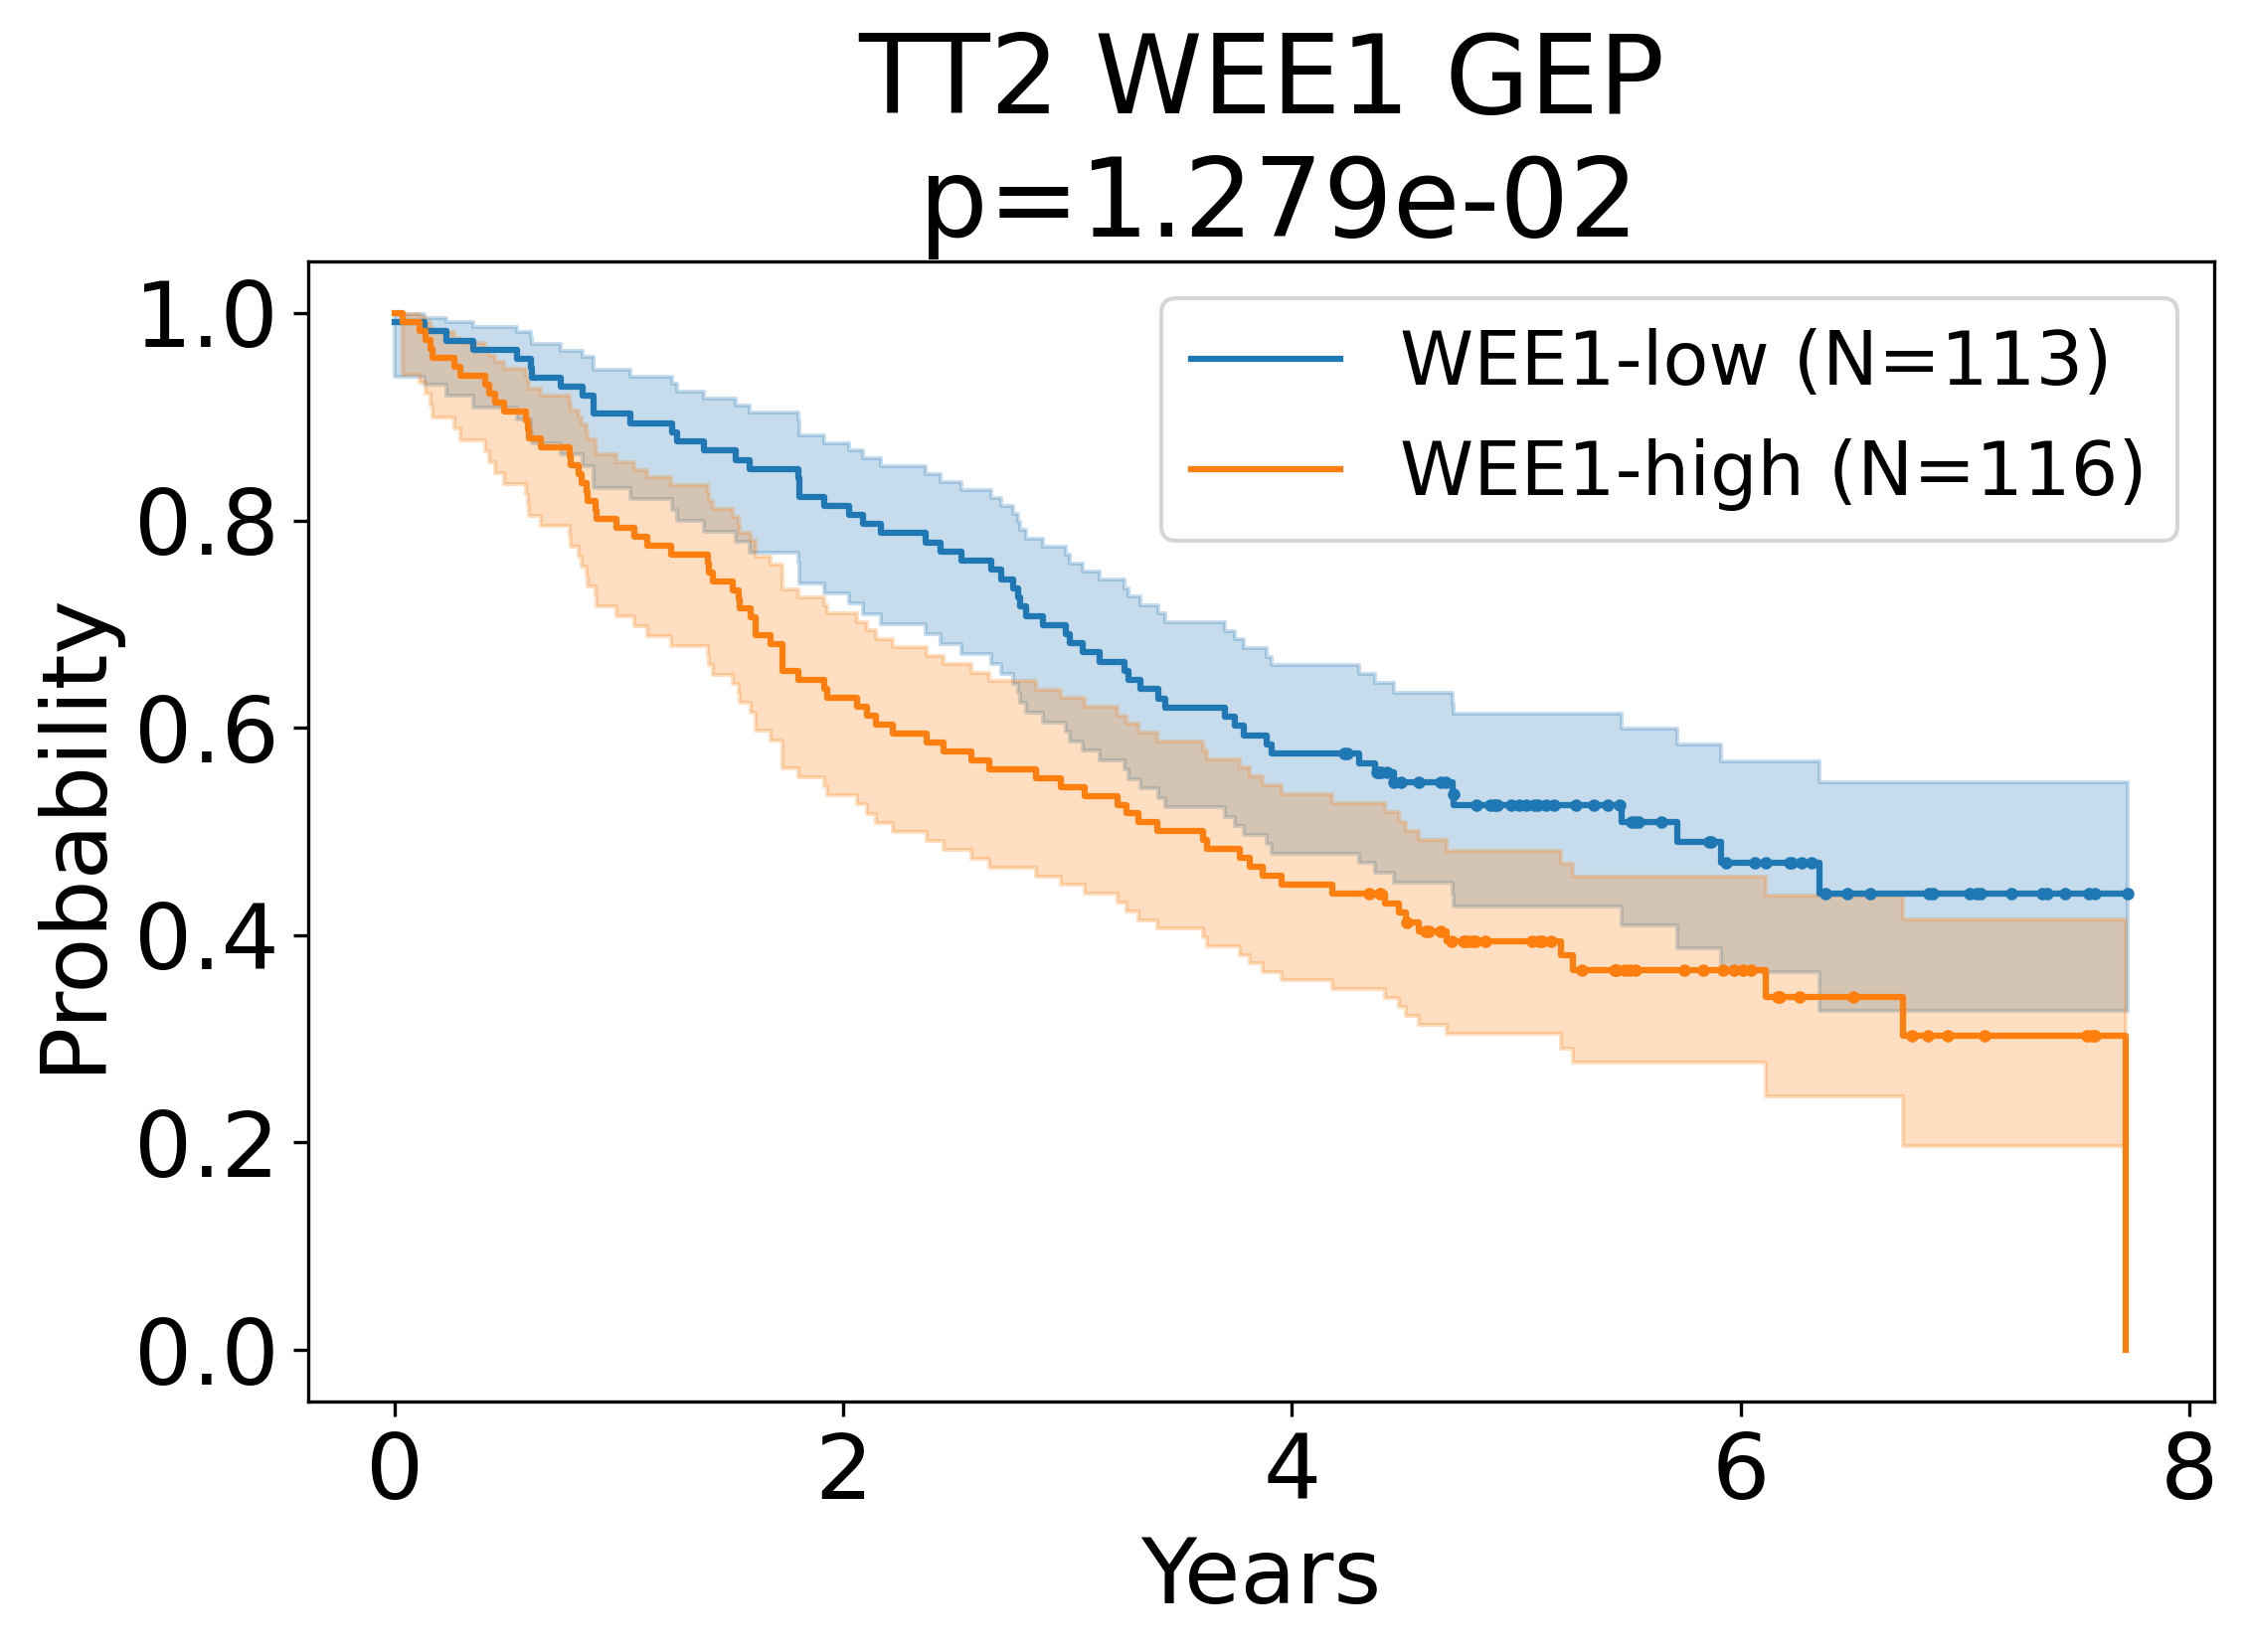

In [23]:
clin_data_tt = clin_data[clin_data['PROT'].isin(['TT2'])]

event_duration = clin_data_tt['EFS TIME JUN2008'].values
censorlist = clin_data_tt['EFS CENSOR (1=event) JUN2008'].values
wee1_data = clin_data_tt['WEE1'].values

WEE1_low_mask = wee1_data < np.percentile(wee1_data, 33)
WEE1_high_mask = wee1_data > np.percentile(wee1_data, 66)
WEE1_mask = WEE1_low_mask + WEE1_high_mask
wee1_labels = 1*WEE1_low_mask + 2*WEE1_high_mask

event_duration = event_duration[WEE1_mask]
event_duration = event_duration/12
censorlist = censorlist[WEE1_mask]
wee1_labels = wee1_labels[WEE1_mask]

print(len(wee1_labels))

plt.figure(dpi=300, figsize=(8, 6))
ax = plt.subplot(111)

output = multivariate_logrank_test(event_duration, wee1_labels, censorlist)
wee1_text_labels = ['empty', 'low', 'high']

kmf = KaplanMeierFitter()
for ncluster in range(1, 3): 
    kmf.fit(event_duration[wee1_labels==ncluster],\
            censorlist[wee1_labels==ncluster],\
            label="WEE1-"+wee1_text_labels[ncluster]+ " (N="+ str(sum(wee1_labels==ncluster)) +")")
    
    kmf.plot_survival_function(ax=ax,  show_censors=True,\
                               censor_styles={'ms': 2, 'marker': 'o'}, ci_show=True)
    print(ncluster, kmf.median_survival_time_, ' months')
plt.title("TT2 WEE1 GEP\n p=" + "{:.3e}".format(output.p_value))
plt.xlabel('Years')
plt.ylabel('Probability')
plt.rcParams.update({'font.size': 22})
plt.legend(loc='upper right', fontsize="18")
plt.tight_layout()

# plt.savefig('km_tt2.png')


144
1 inf  months
2 inf  months


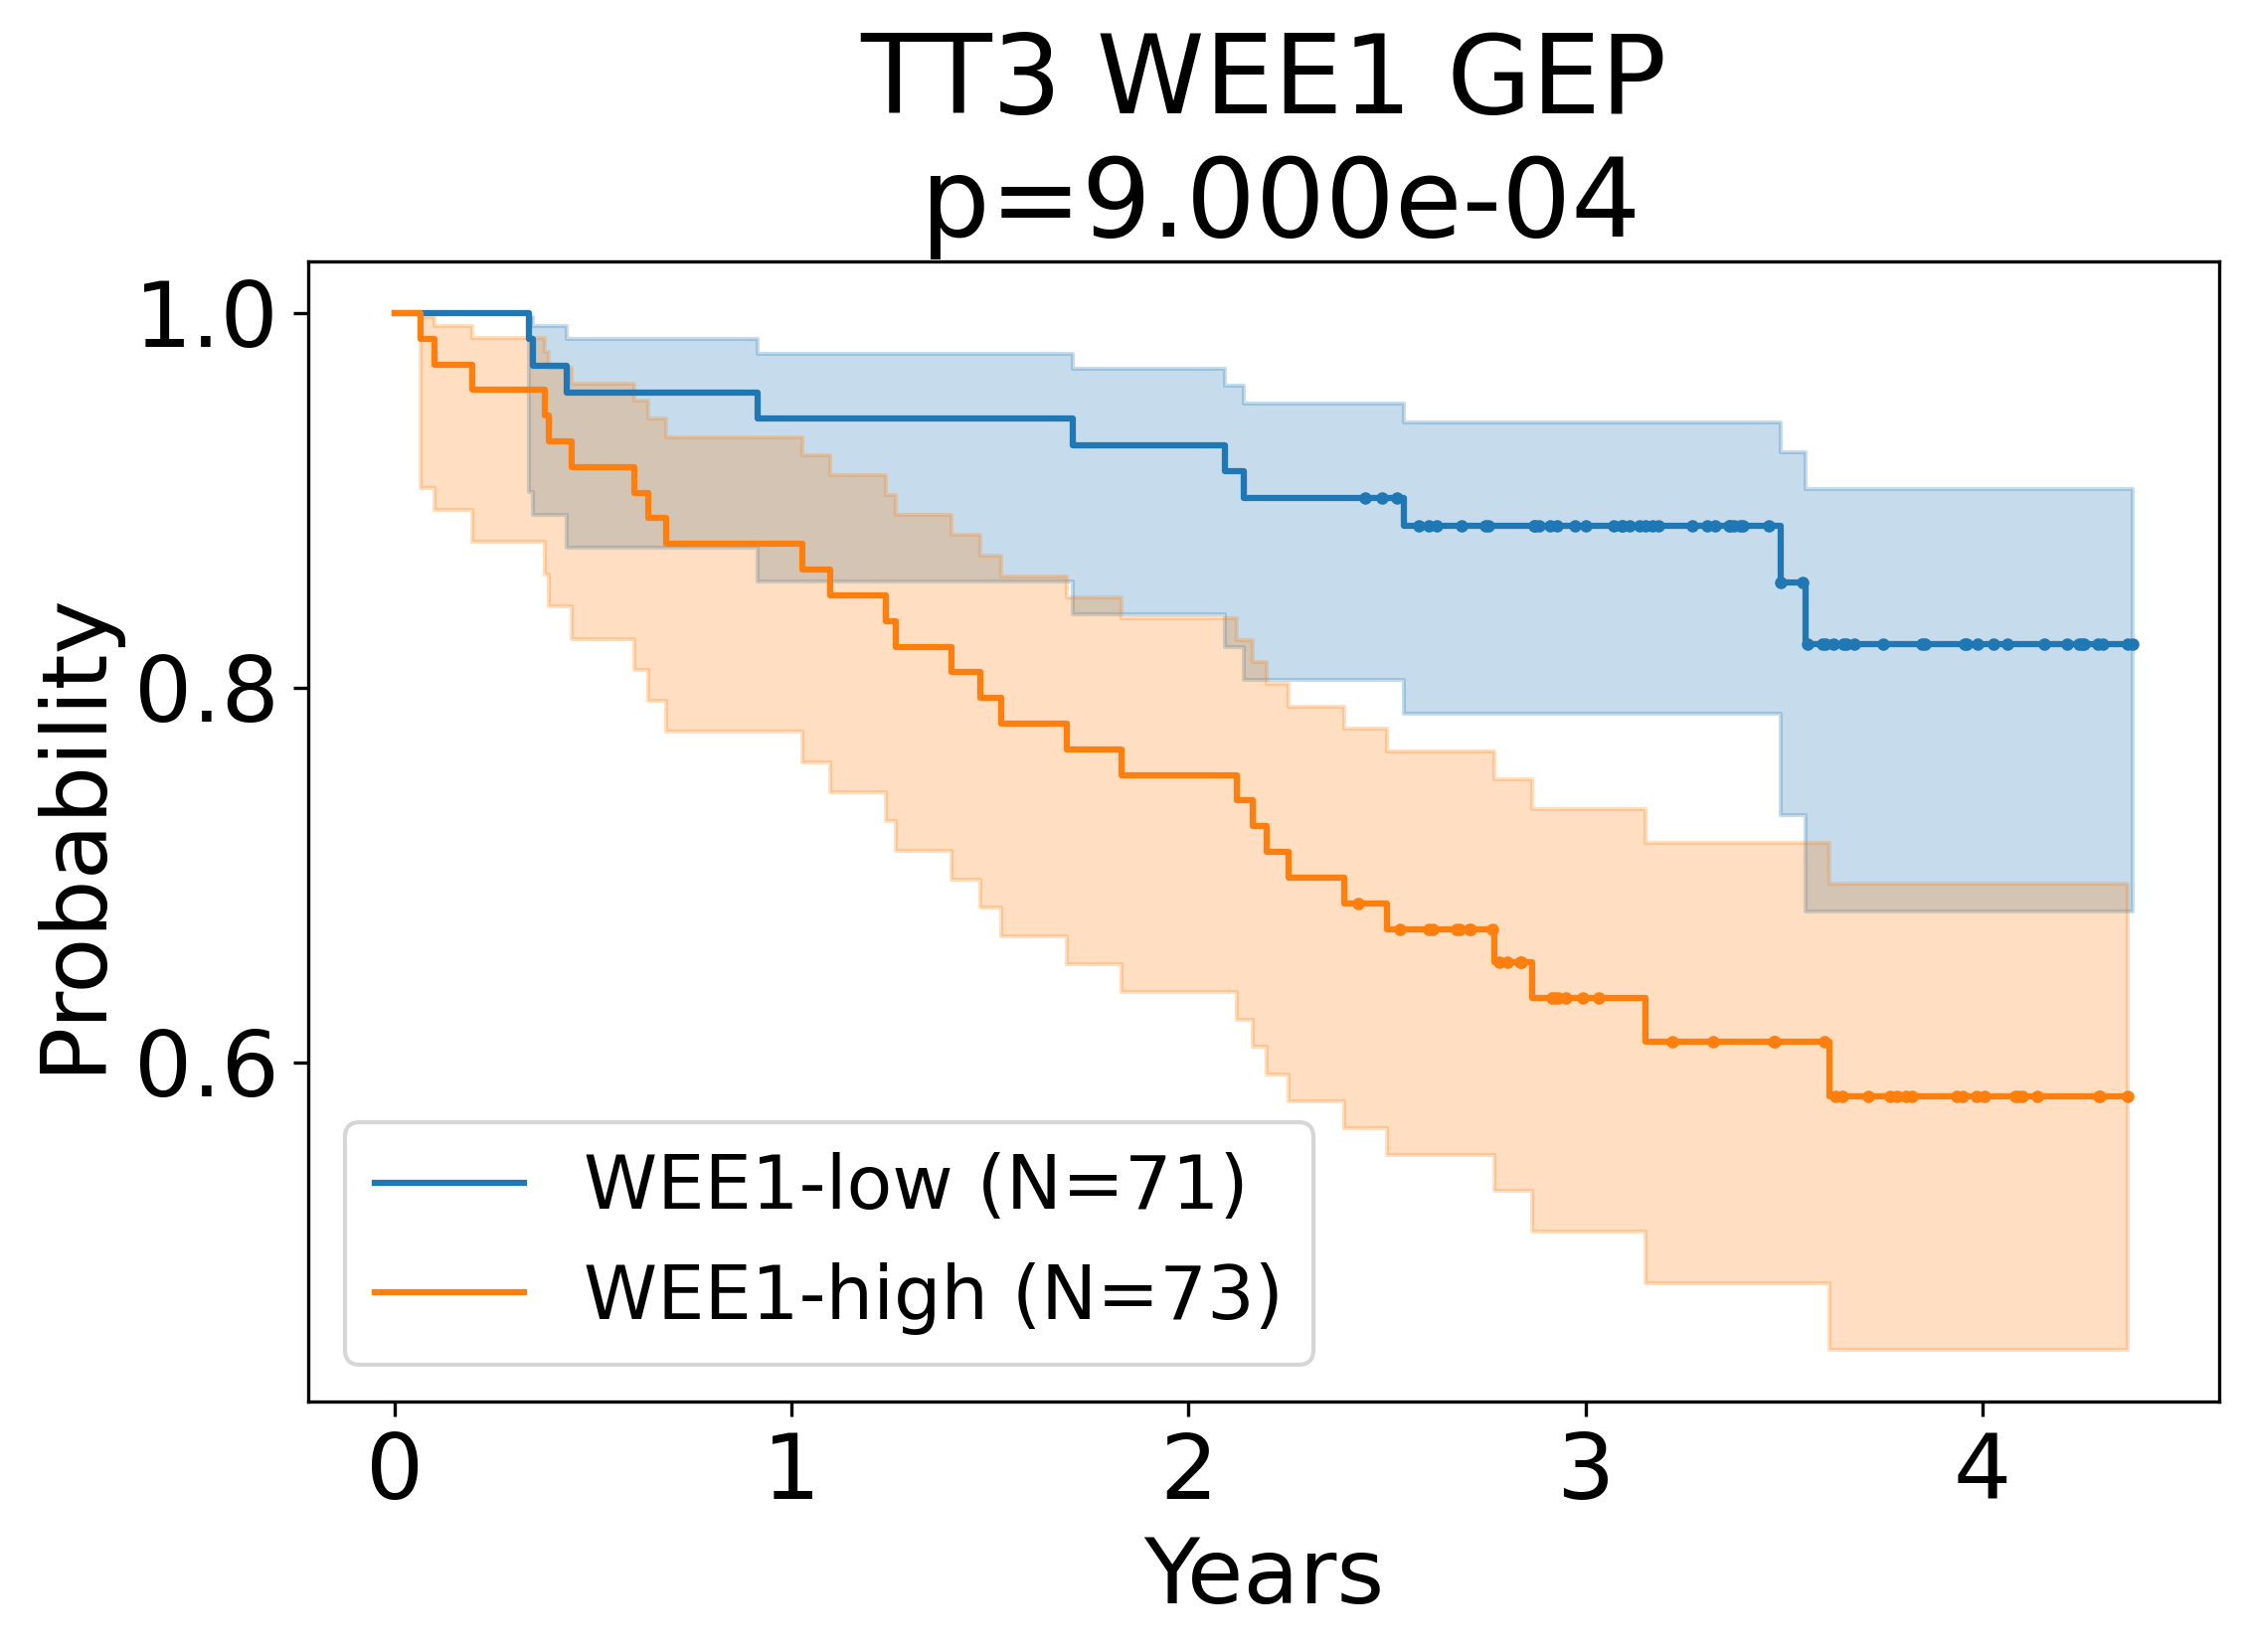

In [26]:
clin_data_tt = clin_data[clin_data['PROT'].isin(['TT3'])]

event_duration = clin_data_tt['EFS TIME JUN2008'].values
censorlist = clin_data_tt['EFS CENSOR (1=event) JUN2008'].values
wee1_data = clin_data_tt['WEE1'].values

WEE1_low_mask = wee1_data < np.percentile(wee1_data, 33)
WEE1_high_mask = wee1_data > np.percentile(wee1_data, 66)
WEE1_mask = WEE1_low_mask + WEE1_high_mask
wee1_labels = 1*WEE1_low_mask + 2*WEE1_high_mask

event_duration = event_duration[WEE1_mask]
event_duration = event_duration/12
censorlist = censorlist[WEE1_mask]
wee1_labels = wee1_labels[WEE1_mask]

print(len(wee1_labels))

plt.figure(dpi=300, figsize=(8, 6))
ax = plt.subplot(111)

output = multivariate_logrank_test(event_duration, wee1_labels, censorlist)
wee1_text_labels = ['empty', 'low', 'high']

kmf = KaplanMeierFitter()
for ncluster in range(1, 3): 
    kmf.fit(event_duration[wee1_labels==ncluster],\
            censorlist[wee1_labels==ncluster],\
            label="WEE1-"+wee1_text_labels[ncluster]+ " (N="+ str(sum(wee1_labels==ncluster)) +")")
    
    kmf.plot_survival_function(ax=ax,  show_censors=True,\
                               censor_styles={'ms': 2, 'marker': 'o'}, ci_show=True)
    print(ncluster, kmf.median_survival_time_, ' months')
plt.title("TT3 WEE1 GEP\n p=" + "{:.3e}".format(output.p_value))
plt.xlabel('Years')
plt.ylabel('Probability')
plt.rcParams.update({'font.size': 22})
plt.legend(loc='lower left', fontsize="18")
plt.tight_layout()
# plt.savefig('km_tt3.png')


In [27]:
clin_data

,index,GSE_ID,PROT,WEE1,CELfilename,EFS CENSOR (1=event) JUN2008,EFS TIME JUN2008,OS CENSOR (1=death) JUN2008,OS TIME JUN2008
0,4,GSM592395,TT2,3.055126,P0015-01-A016-U133Plus-2,1,42.666667,1,42.666667
1,5,GSM592396,TT2,3.385321,P0016-01-A21-U133Plus-2,0,90.800000,0,90.800000
2,6,GSM592397,TT2,3.033229,P0018-01-A30-U133Plus-2,1,33.133333,0,96.266667
3,7,GSM592398,TT2,3.100692,P0019-01-A40-U133Plus-2,1,21.266667,1,38.266667
4,8,GSM592399,TT2,3.203045,P0025-01-A53-U133Plus-2,0,91.900000,0,91.900000
...,...,...,...,...,...,...,...,...,...
550,560,GSM592657,TT3,3.395858,P1635-01-E988-U133Plus-2,0,31.266667,0,31.266667
551,561,GSM592658,TT3,3.272844,P1639-01-F130-U133Plus-2,1,0.766667,1,0.766667
552,562,GSM592659,TT3,3.178699,P1644-01-F006-U133Plus-2,0,30.700000,0,30.700000
553,563,GSM592660,TT3,2.808055,P1645-01-F048-U133Plus-2,0,29.833333,0,29.833333
